In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt

In [4]:
!head ./ks-projects-201801.csv

In [5]:
all_data = pd.read_csv('./ks-projects-201801.csv')
BETTER_COLUMN_NAMES = {
    'KickstartedId': 'ID',
    'Categoria': 'category',
    'CateriaPrincipal': 'main_category',
    'FechaLimite': 'deadline',
    'Moneda': 'currency',
    'Meta': 'goal',
    'FechaCreacion': 'launched',
    'TotalInvertido': 'pledged',
    'Estado': 'state',
    'Contribuidores': 'backers',
    'Pais': 'country',
    'TotalInvertidoEnDolar': 'usd pledged',
}
all_data.rename(columns=BETTER_COLUMN_NAMES, inplace=True)

all_data.set_index('ID', inplace=True)

all_data.shape

(378661, 14)

In [6]:
all_data.isnull().sum()

name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

# Variables

## Salida
- state. Valores posibles (suspended,live,undefined,canceled,successfull,state)

## Entrada
- main_category: categoría. Valores posibles (Music,Publishing,Film & Video,Dance,Journalist,Crafts,Photography,Comics,Theater,Fashion,Food,Art,Desing,Techonogy,Games) string
- Countday: Cantidad de dìas entre la diferencia de launched y deadline. float
- backers: Patrocinadores
- country: País del kickstarter
- pledged: invertido.
- usd_pledged_real: inversión en dolares
- usd_goal_real: Meta convertida en dolar.


## No utilizaremos como entradas
- ID:  Esto puede generar sobreentrenamiento
- name: Esto tiene un gran cambio que puede conducir a sobreentrenamiento.
- category: Subcategoría que puede generar duplicidad con el parámetro main_category.
- currency: Se duplica de country y por lo tanto puede generar sobreentrenamiento.
- usd_pledged: inversión en dolares, contiene valores en null, ademas es igual a usd_pledged_real que no tiene valores en null
- deadline y launched: Fecha límite y fecha de lanzamiento del kickstarter se utilizara countday para reflejar la cantidad de dias entre los mismos.

## Transformacion de variable
Para la variable countday se pasa deadline y launched a formato date, luego se saca la cantidad de dias entre las mismas.

In [7]:
all_data['deadline']=pd.to_datetime(all_data['deadline'])
all_data['launched']=pd.to_datetime(all_data['launched'])
all_data['countday']=all_data['deadline'] - all_data['launched']
all_data['countday']= all_data['countday'].astype('timedelta64[D]')
all_data

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,countday
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,58.0
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,59.0
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,44.0
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,29.0
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,55.0
1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00,34.0
1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00,19.0
1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00,44.0
1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00,34.0


# Variable de salida

Para la variable State definimos que los valores predecibles van a ser: failed, suspended, canceled y successful. Valores como “live” y “undefined” generan outliers en el set de datos ya que es ínfima la cantidad que representan (1% c/u), lo conveniente es descartarlos para evitar que el modelo pueda deformar sus predicciones para tratar de predecirlos bien.


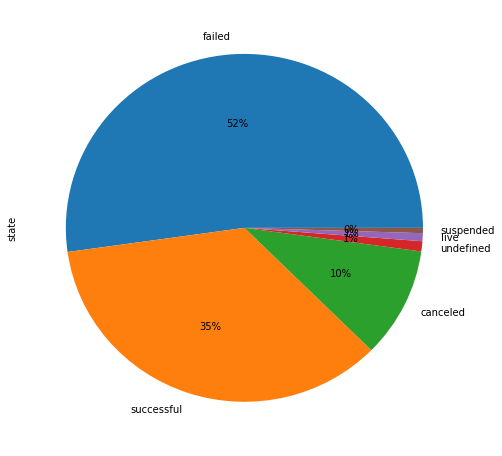

In [8]:
all_data.state.value_counts().plot.pie(autopct='%1.0f%%', figsize=(8,8))

## Distribución de los kickstarter por categoria

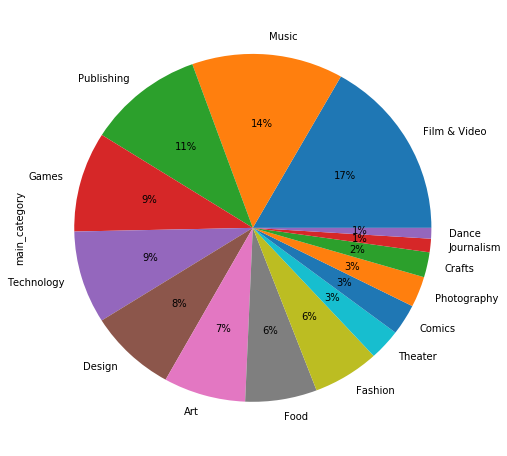

In [9]:
all_data.main_category.value_counts().plot.pie(autopct='%1.0f%%', figsize=(8,8))

## Resultado del kickstarter por cada categoria
Se puede observar que las categorias con mayor tasa de exito son baile, teatro y comics

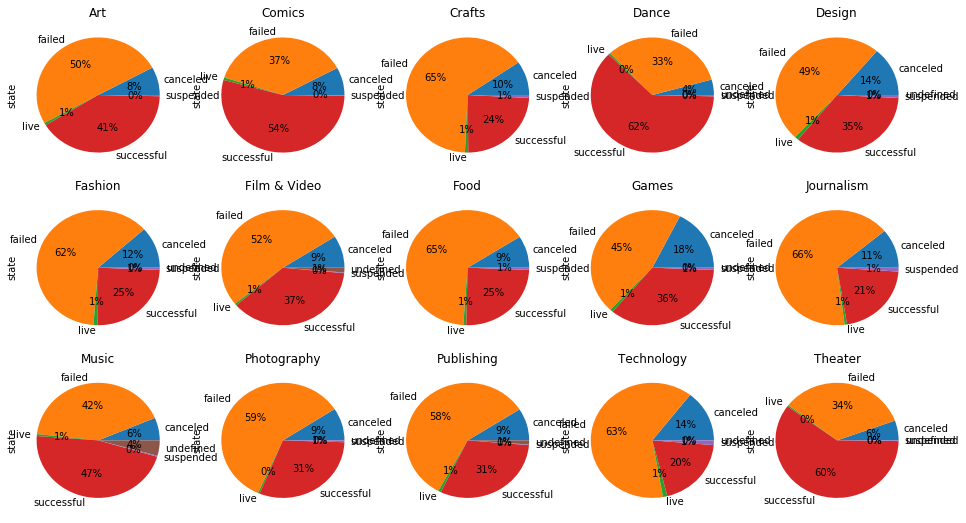

In [10]:
fig, axes = plt.subplots(nrows=3, ncols= 5, figsize=(16,9))
axes = axes.ravel()
for c, i in zip(np.sort(all_data.main_category.unique()), range(15)):
    all_data[all_data.main_category == c].state.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=axes[i])
    axes[i].set_title(c)

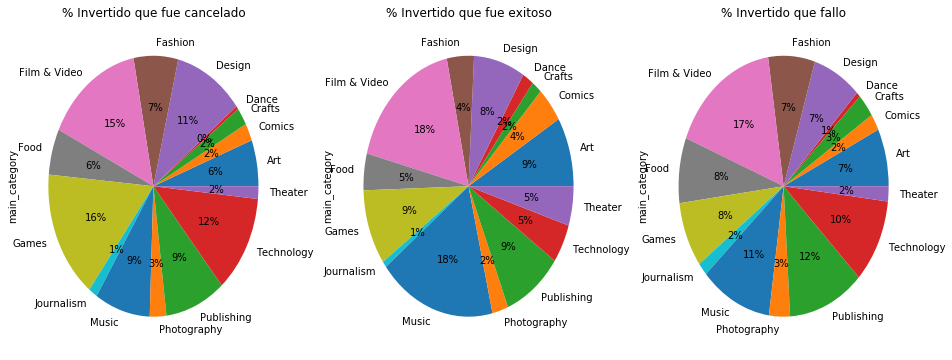

In [11]:
f,ax=plt.subplots(1,3,figsize=(16,6))

ax[0].set_title('% Invertido que fue cancelado')
all_data[all_data.state == 'canceled'].main_category.value_counts().sort_index().plot.pie(ax=ax[0], autopct='%1.0f%%')
ax[1].set_title('% Invertido que fue exitoso')
all_data[all_data.state == 'successful'].main_category.value_counts().sort_index().plot.pie(ax=ax[1], autopct='%1.0f%%')
ax[2].set_title('% Invertido que fallo')
all_data[all_data.state == 'failed'].main_category.value_counts().sort_index().plot.pie(ax=ax[2], autopct='%1.0f%%')

## Cantidad de dias a exito

La cantidad de dias para que un kickstarter tuvo succeso

In [12]:
all_data[all_data.main_category.notnull()][['main_category'],['countday']].boxplot(by='main_category')

TypeError: unhashable type: 'list'

<function matplotlib.pyplot.show>

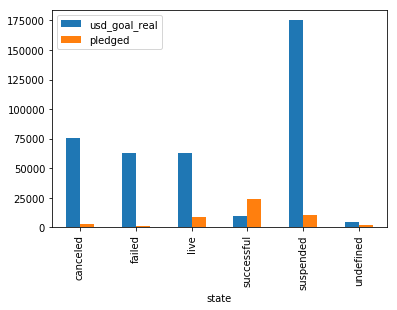

In [19]:
all_data.groupby('state').mean().loc[:,['usd_goal_real','pledged']].plot(kind='bar')
plt.show